In [7]:
import pandas as pd

# Load CSV with low_memory=False and site_id as string to avoid warnings
file_path = r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\AFoster_data_merged_with_zonal.csv"
df = pd.read_csv(file_path, low_memory=False, dtype={'site_id': str})

# Extract date in YYYY_MM_DD format from raster_file
df['date'] = pd.to_datetime(df['raster_file'].str.extract(r'(\d{4}_\d{2}_\d{2})')[0], format='%Y_%m_%d')

# Verify
print(df[['raster_file', 'date']].head())


                     raster_file       date
0  SAN_LST_2019_02_19_070351.tif 2019-02-19
1  SAN_LST_2019_05_27_171714.tif 2019-05-27
2  SAN_LST_2019_06_07_130258.tif 2019-06-07
3  SAN_LST_2019_06_08_202132.tif 2019-06-08
4  SAN_LST_2019_06_11_112151.tif 2019-06-11


In [11]:
# Confirm your LST column — assuming it's 'mean_C' from your previous message
lst_column = 'mean_C'

# Step 1: Compute daily average LST across all sites
daily_mean_LST = df.groupby('date')[lst_column].mean()

# Step 2: Get 95th percentile threshold
threshold = daily_mean_LST.quantile(0.95)
print(f" Top 5% LST threshold: {threshold:.2f} °C")

# Step 3: Extract dates above the threshold
extreme_heat_dates = daily_mean_LST[daily_mean_LST > threshold].index
print(f"  Number of extreme heat days: {len(extreme_heat_dates)}")


 Top 5% LST threshold: 41.95 °C
  Number of extreme heat days: 19


In [13]:
# Add a binary column to mark if that row is during an extreme heat event
df['heat_event'] = df['date'].isin(extreme_heat_dates)
print(df['heat_event'].value_counts())  # See how many True/False


heat_event
False    612720
True      31592
Name: count, dtype: int64


In [15]:
output_path = r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\AFoster_with_heat_flags.csv"
df.to_csv(output_path, index=False)


In [19]:
# Load your cluster-labeled CSV
cluster_path = r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\kmeans_clusters_k5_named.csv"
df_clusters = pd.read_csv(cluster_path, dtype={'site_id': str})

# Ensure consistent 'site_id' format
df['site_id'] = df['site_id'].astype(str).str.strip()
df_clusters['site_id'] = df_clusters['site_id'].astype(str).str.strip()

# Merge cluster labels into the main dataframe
df_merged = df.merge(df_clusters[['site_id', 'cluster_label']], on='site_id', how='left')

# Confirm result
print(f"🔄 Merged shape: {df_merged.shape}")
print(f"❓ Missing cluster labels: {df_merged['cluster_label'].isna().sum()}")
df_clustered = df_merged.dropna(subset=['cluster_label'])
print(f"✔ Rows with cluster labels: {df_clustered.shape[0]}")



🔄 Merged shape: (644312, 20)
❓ Missing cluster labels: 217900
✔ Rows with cluster labels: 426412


C:\Users\jbros\AppData\Local\Temp\ipykernel_33636\2961531579.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_heat, x='cluster_label', y='mean_C', palette='Set2')


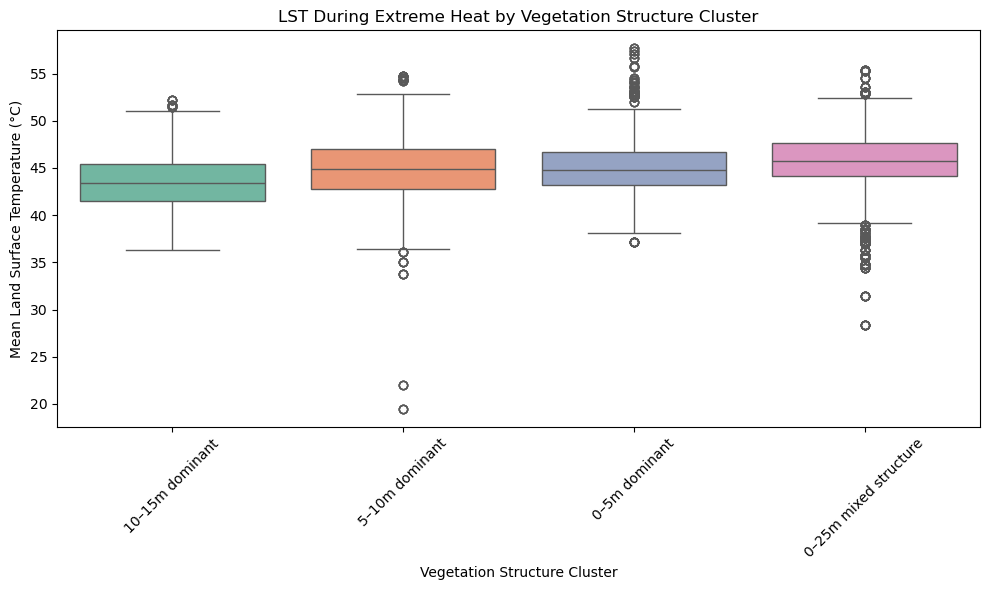

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to rows with cluster labels AND flagged as heat events
df_heat = df_clustered[df_clustered['heat_event'] == True]

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_heat, x='cluster_label', y='mean_C', palette='Set2')
plt.title("LST During Extreme Heat by Vegetation Structure Cluster")
plt.xlabel("Vegetation Structure Cluster")
plt.ylabel("Mean Land Surface Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
# Mean and std LST during heat events per cluster
summary = df_heat.groupby('cluster_label')['mean_C'].agg(['mean', 'std', 'count']).sort_values('mean')
print(summary)


                            mean       std  count
cluster_label                                    
10–15m dominant        43.536499  2.924638   3417
5–10m dominant         44.843644  3.141485   9305
0–5m dominant          44.969039  2.734549   6314
0–25m mixed structure  45.233392  4.205441   1778


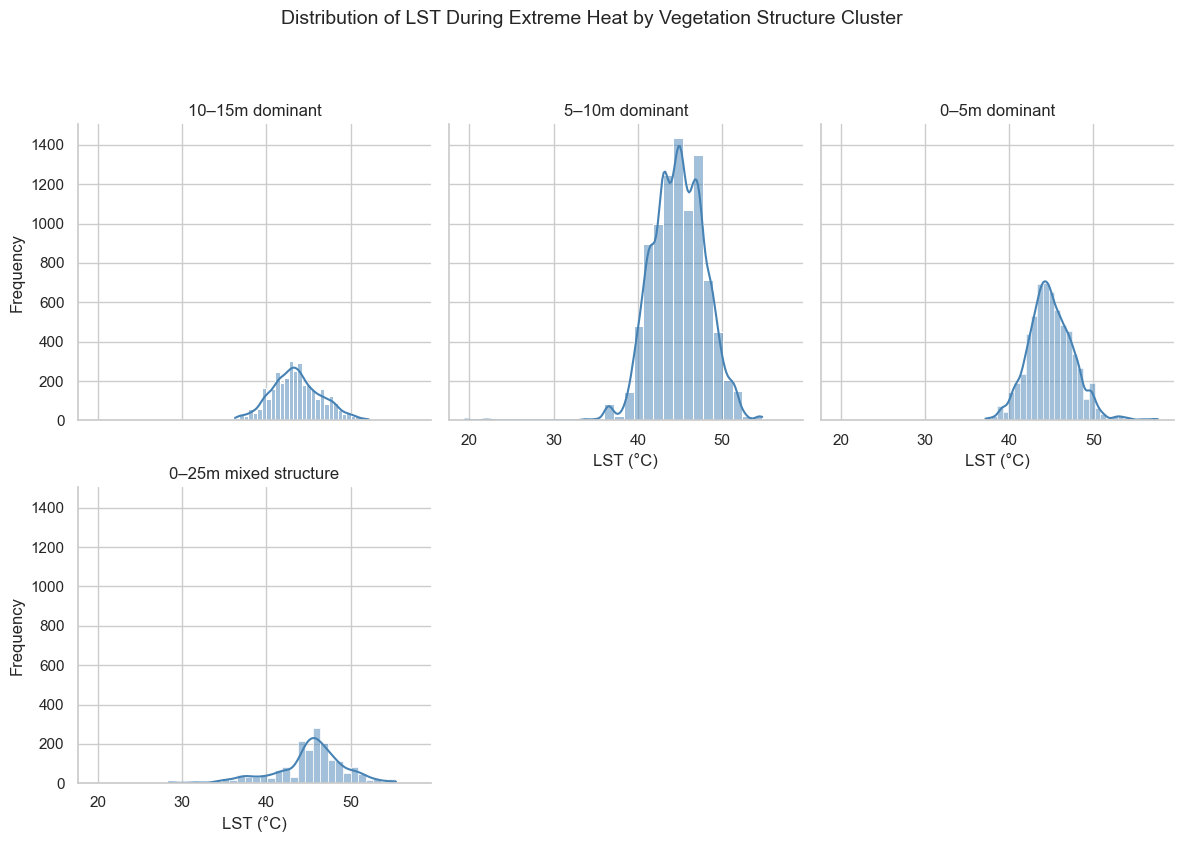

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to heat event rows with cluster labels
df_heat = df_clustered[df_clustered['heat_event'] == True]

# Set plot style
sns.set(style="whitegrid")

# Plot: Histogram of mean_C for each cluster
g = sns.FacetGrid(df_heat, col="cluster_label", col_wrap=3, sharex=True, sharey=True, height=4)
g.map_dataframe(sns.histplot, x="mean_C", bins=30, kde=True, color="steelblue")

# Customize
g.set_axis_labels("LST (°C)", "Frequency")
g.set_titles("{col_name}")
plt.suptitle("Distribution of LST During Extreme Heat by Vegetation Structure Cluster", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()



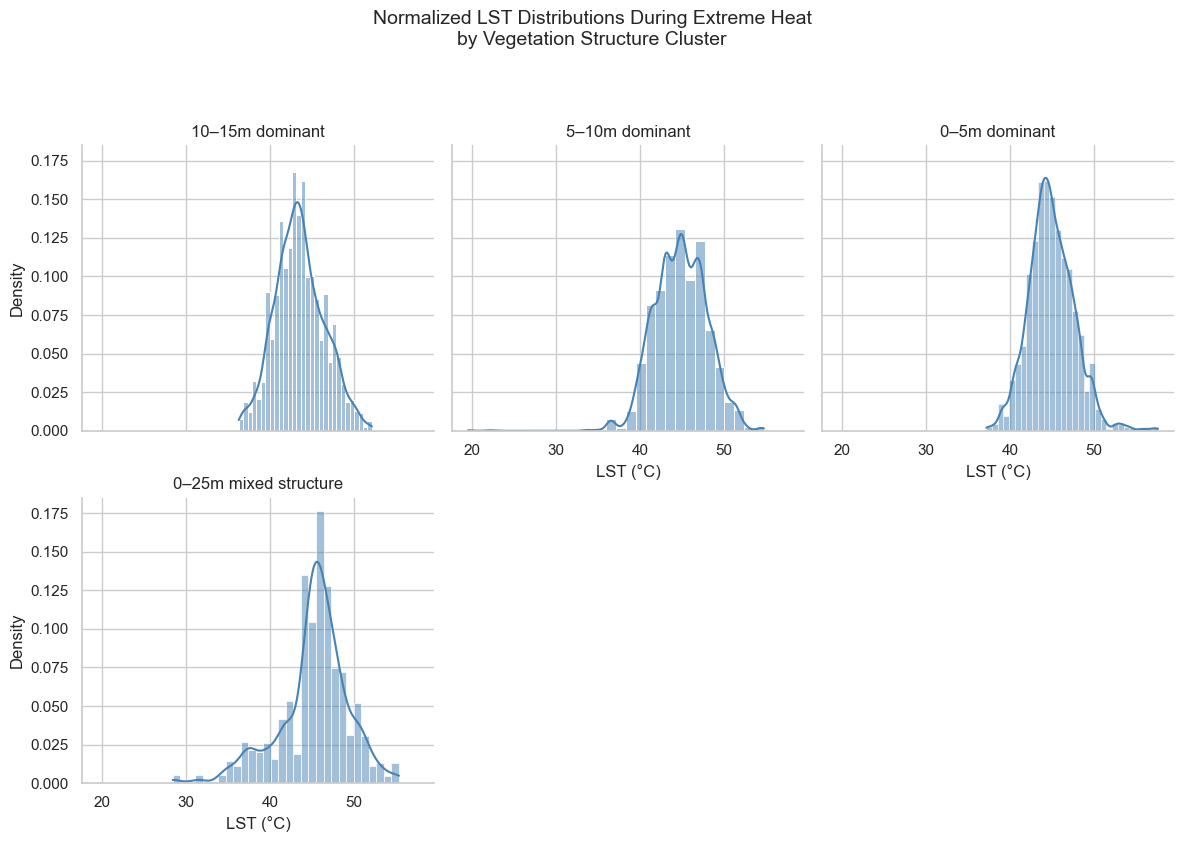

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only rows during heat events, and with valid cluster labels
df_heat = df_clustered[df_clustered['heat_event'] & df_clustered['cluster_label'].notna()]

# Faceted histogram by cluster — normalized to density
g = sns.FacetGrid(df_heat, col="cluster_label", col_wrap=3, height=4, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="mean_C", bins=30, stat='density', kde=True, color="steelblue")

g.set_axis_labels("LST (°C)", "Density")
g.set_titles("{col_name}")
plt.suptitle("Normalized LST Distributions During Extreme Heat\nby Vegetation Structure Cluster", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


C:\Users\jbros\AppData\Local\Temp\ipykernel_33636\3136848625.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_heat, x='cluster_label', y='mean_C', inner='quartile', palette='Set2')


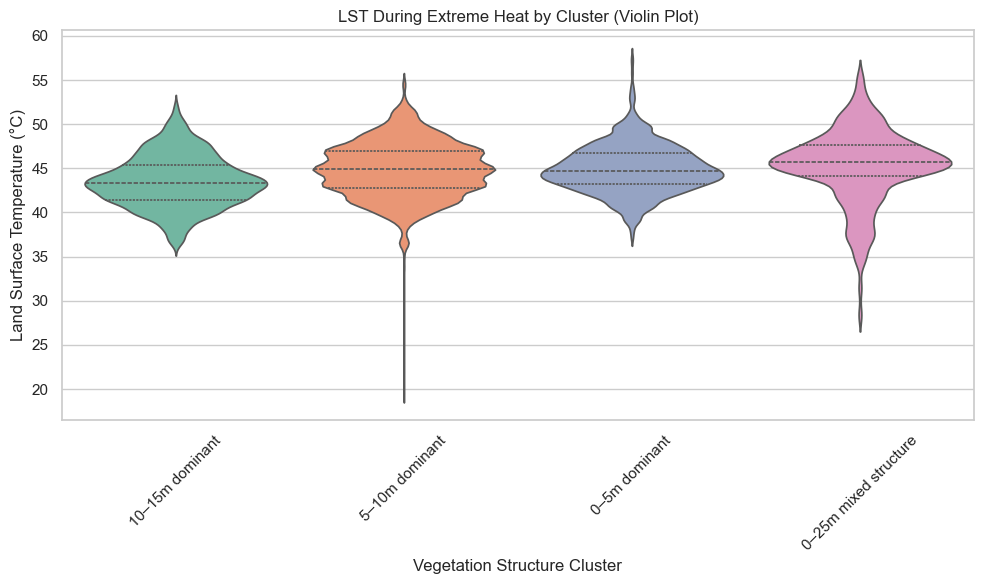

In [29]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_heat, x='cluster_label', y='mean_C', inner='quartile', palette='Set2')
plt.title("LST During Extreme Heat by Cluster (Violin Plot)")
plt.xlabel("Vegetation Structure Cluster")
plt.ylabel("Land Surface Temperature (°C)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


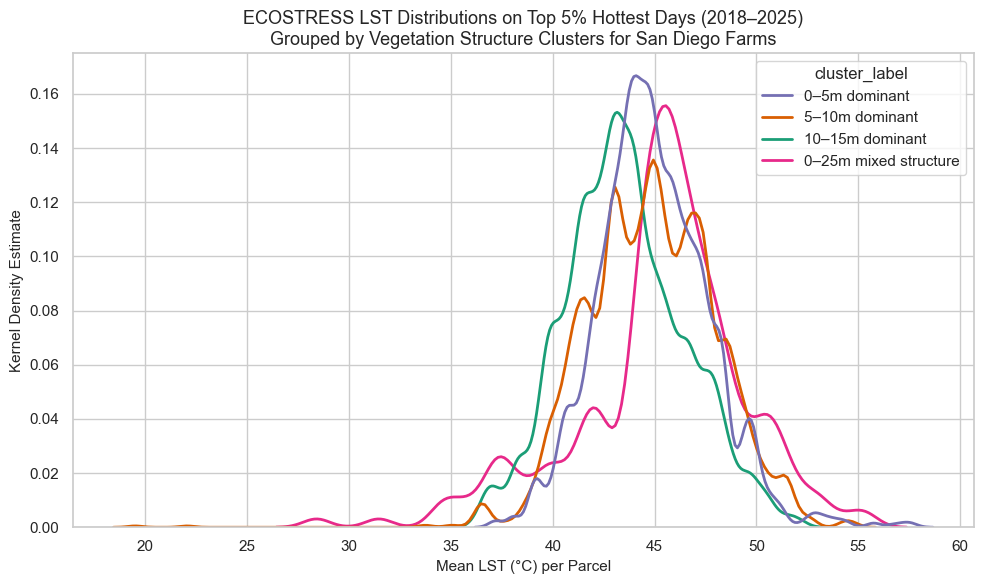

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data
df_heat = df_clustered[df_clustered['heat_event'] & df_clustered['cluster_label'].notna()]

# Define custom color mapping (same as PCA plot)
custom_palette = {
    "0–5m dominant": "#7570b3",
    "5–10m dominant": "#d95f02",
    "10–15m dominant": "#1b9e77",
    "0–25m mixed structure": "#e7298a"
}

# Define the desired order explicitly
ordered_clusters = [
    "0–5m dominant",
    "5–10m dominant",
    "10–15m dominant",
    "0–25m mixed structure"
]

# Plot KDE with ordered legend
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_heat,
    x="mean_C",
    hue="cluster_label",
    hue_order=ordered_clusters,
    palette=custom_palette,
    common_norm=False,
    bw_adjust=0.7,
    fill=False,
    linewidth=2
)

plt.title("ECOSTRESS LST Distributions on Top 5% Hottest Days (2018–2025)\nGrouped by Vegetation Structure Clusters for San Diego Farms", fontsize=13)
plt.xlabel("Mean LST (°C) per Parcel", fontsize=11)
plt.ylabel("Kernel Density Estimate", fontsize=11)
plt.tight_layout()
plt.show()


In [58]:
print(df_heat['cluster_label'].value_counts())


cluster_label
5–10m dominant           9305
0–5m dominant            6314
10–15m dominant          3417
0–25m mixed structure    1778
Name: count, dtype: int64


In [33]:
df_heat.groupby("cluster_label")["mean_C"].agg(["count", "mean", "std", "min", "max"])


,count,mean,std,min,max
cluster_label,,,,,
0–25m mixed structure,1778,45.233392,4.205441,28.402568,55.394167
0–5m dominant,6314,44.969039,2.734549,37.181667,57.671887
10–15m dominant,3417,43.536499,2.924638,36.270870,52.165531
5–10m dominant,9305,44.843644,3.141485,19.492909,54.781729


In [35]:
from scipy.stats import f_oneway

# Split data by cluster
groups = [group["mean_C"].values for _, group in df_heat.groupby("cluster_label")]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F = {f_stat:.2f}, p = {p_value:.4f}")


ANOVA F = 200.82, p = 0.0000


In [37]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df_heat['mean_C'], groups=df_heat['cluster_label'], alpha=0.05)
print(tukey.summary())


            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
        group1             group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
0–25m mixed structure   0–5m dominant  -0.2644 0.0081  -0.478 -0.0507   True
0–25m mixed structure 10–15m dominant  -1.6969    0.0 -1.9296 -1.4642   True
0–25m mixed structure  5–10m dominant  -0.3897    0.0 -0.5957 -0.1838   True
        0–5m dominant 10–15m dominant  -1.4325    0.0 -1.6016 -1.2635   True
        0–5m dominant  5–10m dominant  -0.1254 0.0626 -0.2552  0.0044  False
      10–15m dominant  5–10m dominant   1.3071    0.0   1.148  1.4663   True
----------------------------------------------------------------------------


In [39]:
from scipy.stats import kruskal

kruskal_stat, kruskal_p = kruskal(*groups)
print(f"Kruskal-Wallis H = {kruskal_stat:.2f}, p = {kruskal_p:.4f}")


Kruskal-Wallis H = 706.07, p = 0.0000


In [41]:
# Check cluster counts across all data
print(df_clustered['cluster_label'].value_counts())

# Now check again, only during heat events
print(df_heat['cluster_label'].value_counts())


cluster_label
5–10m dominant           190019
0–5m dominant            130218
10–15m dominant           70298
0–25m mixed structure     35855
0–40m mixed structure        22
Name: count, dtype: int64
cluster_label
5–10m dominant           9305
0–5m dominant            6314
10–15m dominant          3417
0–25m mixed structure    1778
Name: count, dtype: int64
